In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image

In [2]:
original_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

augmented_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
]))


combined_data = torch.utils.data.ConcatDataset([original_data, augmented_data])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),  
    transforms.RandomCrop(32, padding=4),  
    transforms.ToTensor(),  
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [4]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=test_transform)


Files already downloaded and verified


In [5]:
len(testset)

10000

In [6]:
trainloader = torch.utils.data.DataLoader(combined_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

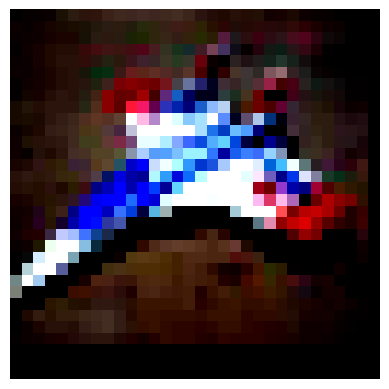

In [7]:
image_tensor=augmented_data[30][0]
image_np = image_tensor.permute(1, 2, 0).numpy()
image_np = image_np.clip(0, 1)
plt.imshow(image_np)
plt.axis("off") 
plt.show()

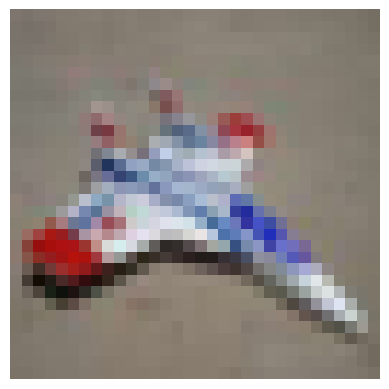

In [8]:
image_tensor=original_data[30][0]
image_np = image_tensor.permute(1, 2, 0).numpy()
image_np = image_np.clip(0, 1)
plt.imshow(image_np)
plt.axis("off") 
plt.show()

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)  
        self.fc4 = nn.Linear(128, 64)   
        self.fc5 = nn.Linear(64, 10)    
        
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        
        x = torch.flatten(x, 1)  
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)  
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.3)
        x = F.relu(self.fc3(x))  
        x = F.relu(self.fc4(x))  
        x = self.fc5(x)  
        return x

In [10]:
net=Net()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [13]:
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [14]:
for epoch in range(100):
    net.train()
    running_loss = 0.0
    for i,(images, labels) in enumerate(trainloader):
        images=images.cuda()
        labels=labels.cuda()
        outputs = net(images)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch}], Loss: {running_loss/len(trainloader):.4f}")

Epoch [0], Loss: 1.6424
Epoch [1], Loss: 1.2689
Epoch [2], Loss: 1.0953
Epoch [3], Loss: 0.9875
Epoch [4], Loss: 0.8988
Epoch [5], Loss: 0.8240
Epoch [6], Loss: 0.7729
Epoch [7], Loss: 0.7185
Epoch [8], Loss: 0.6699
Epoch [9], Loss: 0.6338
Epoch [10], Loss: 0.6033
Epoch [11], Loss: 0.5831
Epoch [12], Loss: 0.5488
Epoch [13], Loss: 0.5323
Epoch [14], Loss: 0.5145
Epoch [15], Loss: 0.4928
Epoch [16], Loss: 0.4760
Epoch [17], Loss: 0.4690
Epoch [18], Loss: 0.4561
Epoch [19], Loss: 0.4430
Epoch [20], Loss: 0.4259
Epoch [21], Loss: 0.4167
Epoch [22], Loss: 0.4128
Epoch [23], Loss: 0.4035
Epoch [24], Loss: 0.3910
Epoch [25], Loss: 0.3882
Epoch [26], Loss: 0.3846
Epoch [27], Loss: 0.3774
Epoch [28], Loss: 0.3757
Epoch [29], Loss: 0.3648
Epoch [30], Loss: 0.3618
Epoch [31], Loss: 0.3604
Epoch [32], Loss: 0.3530
Epoch [33], Loss: 0.3459
Epoch [34], Loss: 0.3426
Epoch [35], Loss: 0.3391
Epoch [36], Loss: 0.3349
Epoch [37], Loss: 0.3353
Epoch [38], Loss: 0.3347
Epoch [39], Loss: 0.3276
Epoch [40]

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Net accuracy for test images: {100 * correct // total} %')

Net accuracy for test images: 83 %
